In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import os

In [3]:
# Load data from CSV
data = pd.read_csv('../data/financial_data_clean.csv', index_col=0, parse_dates=True)

# Ensure business day frequency and handle missing values
data = data.asfreq('B')
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

In [4]:
# Basic statistics
print("Basic Statistics for TSLA:")
print(data[['TSLA_Adj Close', 'TSLA_Volume']].describe())
print("\nBasic Statistics for BND:")
print(data[['BND_Adj Close', 'BND_Volume']].describe())
print("\nBasic Statistics for SPY:")
print(data[['SPY_Adj Close', 'SPY_Volume']].describe())
print("\nMissing Values:")
print(data.isna().sum())


Basic Statistics for TSLA:
       TSLA_Adj Close   TSLA_Volume
count     2632.000000  2.632000e+03
mean       132.390951  1.139731e+08
std        121.311946  7.287823e+07
min          9.578000  1.062000e+07
25%         18.993500  6.911730e+07
50%         96.115669  9.510000e+07
75%        237.016663  1.322356e+08
max        479.859985  9.140820e+08

Basic Statistics for BND:
       BND_Adj Close    BND_Volume
count    2632.000000  2.632000e+03
mean       68.469495  4.413788e+06
std         4.549542  2.871153e+06
min        60.779140  0.000000e+00
25%        64.664339  2.178050e+06
50%        67.610100  4.115500e+06
75%        71.879684  5.868025e+06
max        77.318245  3.396300e+07

Basic Statistics for SPY:
       SPY_Adj Close    SPY_Volume
count    2632.000000  2.632000e+03
mean      334.636737  8.485662e+07
std       126.771239  4.427005e+07
min       155.869751  2.027000e+07
25%       231.115402  5.770420e+07
50%       305.521500  7.441975e+07
75%       420.762863  9.786710e+07


In [6]:
# Calculate daily returns
for ticker in ['TSLA', 'BND', 'SPY']:
    data[f'{ticker}_Daily Return'] = data[f'{ticker}_Adj Close'].pct_change()

# Rolling metrics for volatility (30-day window)
window = 30
for ticker in ['TSLA', 'BND', 'SPY']:
    data[f'{ticker}_Rolling Mean'] = data[f'{ticker}_Adj Close'].rolling(window=window).mean()
    data[f'{ticker}_Rolling Std'] = data[f'{ticker}_Adj Close'].rolling(window=window).std()

# ADF Test for TSLA
adf_close = adfuller(data['TSLA_Adj Close'].dropna())
adf_return = adfuller(data['TSLA_Daily Return'].dropna())
print("\nADF Test for TSLA Adj Close - Statistic:", adf_close[0], "p-value:", adf_close[1])
print("ADF Test for TSLA Daily Return - Statistic:", adf_return[0], "p-value:", adf_return[1])


ADF Test for TSLA Adj Close - Statistic: -1.4897755773697785 p-value: 0.5385630150890253
ADF Test for TSLA Daily Return - Statistic: -15.644244415306089 p-value: 1.6259891178075128e-28


In [7]:
# Outlier detection for TSLA returns
mean_return = data['TSLA_Daily Return'].mean()
std_return = data['TSLA_Daily Return'].std()
outliers = data[np.abs(data['TSLA_Daily Return'] - mean_return) > 3 * std_return]
print("\nOutliers in TSLA Daily Returns:")
print(outliers[['TSLA_Daily Return']])

# Risk metrics
sharpe_tsla = data['TSLA_Daily Return'].mean() / data['TSLA_Daily Return'].std() * np.sqrt(252)
var_tsla = np.percentile(data['TSLA_Daily Return'].dropna(), 5)
print("\nTSLA Sharpe Ratio:", sharpe_tsla)
print("TSLA 5% VaR (Daily):", var_tsla)


Outliers in TSLA Daily Returns:
            TSLA_Daily Return
2015-11-04           0.111735
2018-08-02           0.161880
2018-09-28          -0.139015
2018-10-01           0.173471
2018-10-23           0.127189
2019-01-18          -0.129711
2019-07-25          -0.136137
2019-10-24           0.176692
2020-02-03           0.198949
2020-02-04           0.137256
2020-02-05          -0.171758
2020-02-27          -0.128146
2020-03-02           0.113220
2020-03-09          -0.135725
2020-03-12          -0.116172
2020-03-16          -0.185778
2020-03-18          -0.160344
2020-03-19           0.183877
2020-03-24           0.162817
2020-04-13           0.136038
2020-07-06           0.134794
2020-08-12           0.131236
2020-08-17           0.112031
2020-08-31           0.125689
2020-09-08          -0.210628
2020-09-14           0.125832
2021-03-09           0.196412
2021-10-25           0.126616
2021-11-09          -0.119903
2022-01-03           0.135317
2022-01-27          -0.115542
2022-04

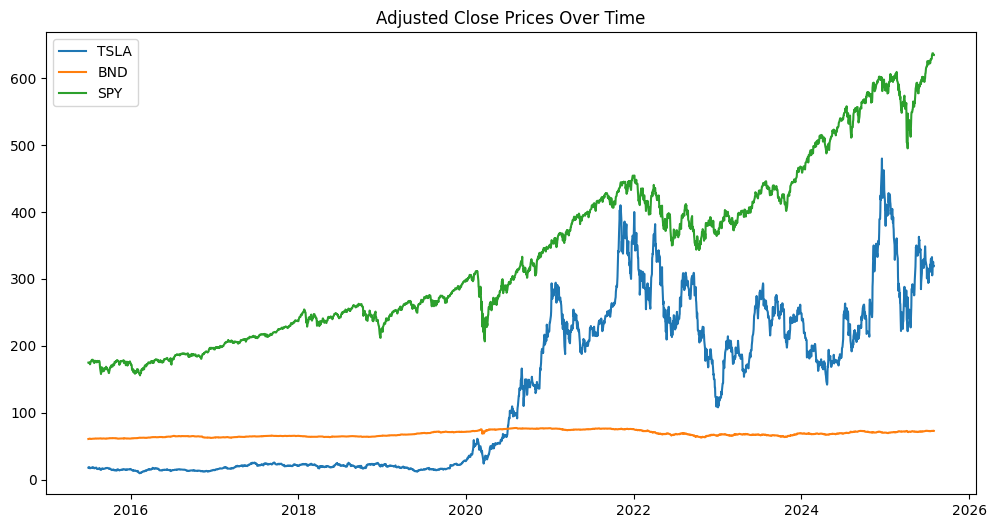

In [19]:
# Visualizations
os.makedirs('../plots', exist_ok=True)
plt.figure(figsize=(12, 6))
plt.plot(data['TSLA_Adj Close'], label='TSLA')
plt.plot(data['BND_Adj Close'], label='BND')
plt.plot(data['SPY_Adj Close'], label='SPY')
plt.title('Adjusted Close Prices Over Time')
plt.legend()
plt.savefig('../plots/adj_close_plot.png')
plt.show()
plt.close()

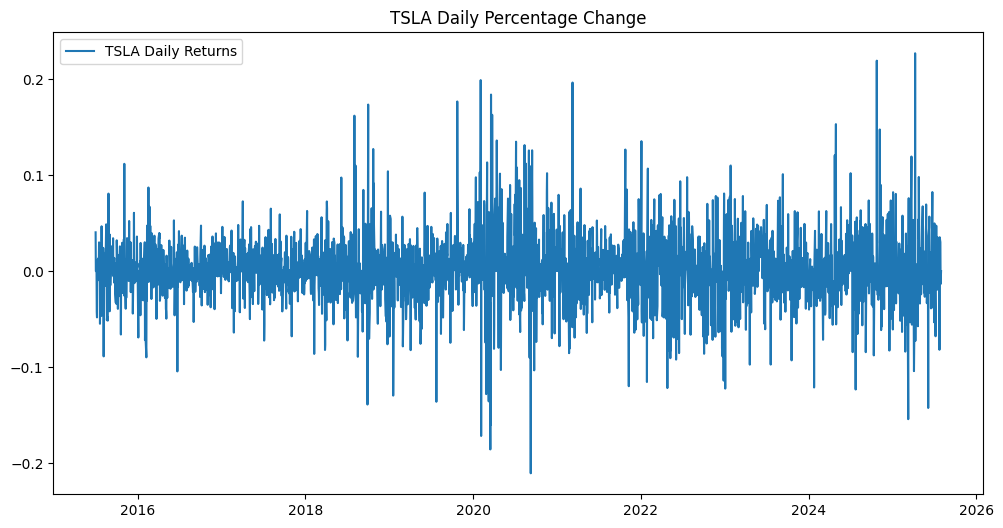

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(data['TSLA_Daily Return'], label='TSLA Daily Returns')
plt.title('TSLA Daily Percentage Change')
plt.legend()
plt.savefig('../plots/tsla_daily_returns_plot.png')
plt.show()
plt.close()

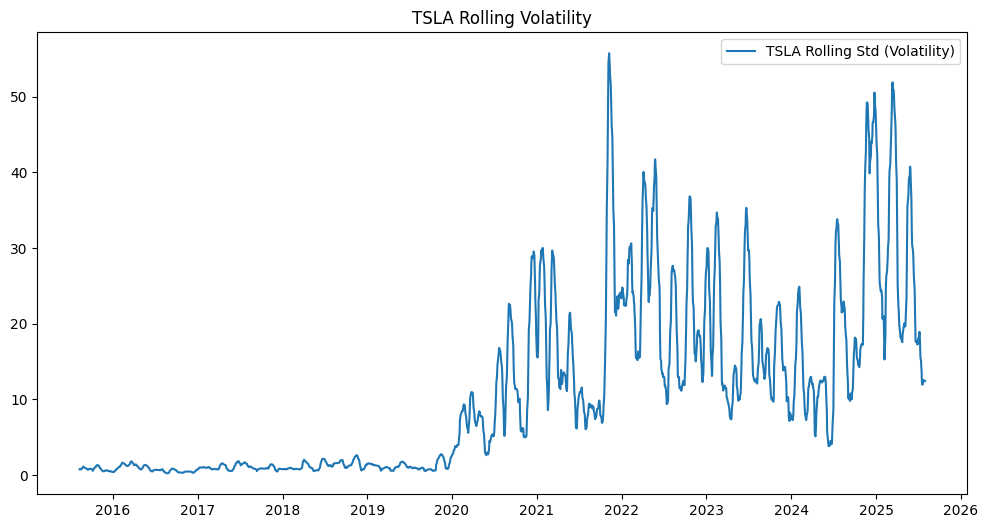

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(data['TSLA_Rolling Std'], label='TSLA Rolling Std (Volatility)')
plt.title('TSLA Rolling Volatility')
plt.legend()
plt.savefig('../plots/tsla_volatility_plot.png')
plt.show()
plt.close()